In [9]:
from keras import layers,losses
from keras.models import Model, Sequential, load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.math import reduce_prod
import matplotlib.pyplot as plt 
import cv2
import os
import numpy as np
import pickle

In [10]:
#Load training set images
train_images=[]
train_image_names=[]

for file_name in os.listdir('./DataBase'):
    train_images.append(cv2.imread('./DataBase/'+file_name,2))
    train_image_names.append(file_name)

train_images = np.asarray(train_images,dtype=np.float32)/255

In [11]:
#Load test set images
test_images=[]
test_image_names=[]

for file_name in os.listdir('./test'):
    test_images.append(cv2.imread('./test/'+file_name,2))
    test_image_names.append(file_name)

test_images = np.asarray(test_images,dtype=np.float32)/255

In [12]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, use_bias=False, activation='linear'),
    ])
    self.decoder = Sequential([
      layers.Dense(reduce_prod(shape), use_bias=False, activation='linear'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


If the models are already trained and saved you can skip the next 5 cells and run the ones below directly

In [13]:
#Compling three autoencoders with different sized latent dimensions

shape = train_images.shape[1:]

autoencoder_100 = Autoencoder(100, shape)
autoencoder_50 = Autoencoder(50, shape)
autoencoder_10 = Autoencoder(10,shape)

autoencoder_100.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_50.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_10.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
#Create model checkpoints to save the models

save_callback_100 = ModelCheckpoint(filepath='./models/autoencoder_100', save_weights_only=False,
                                    monitor='val_loss', 
                                    mode='min', save_best_only=True)

save_callback_50 = ModelCheckpoint(filepath='./models/autoencoder_50', save_weights_only=False,
                                    monitor='val_loss', 
                                    mode='min', save_best_only=True)

save_callback_10 = ModelCheckpoint(filepath='./models/autoencoder_10', save_weights_only=False,
                                    monitor='val_loss', 
                                    mode='min', save_best_only=True)

In [ ]:
autoencoder_100.fit(train_images, train_images,
                epochs=400,
                shuffle=True,
                validation_data=(test_images, test_images), 
                callbacks=[save_callback_100], use_multiprocessing=True)


In [ ]:
autoencoder_50.fit(train_images, train_images,
                epochs=400,
                shuffle=True,
                verbose=1,
                validation_data=(test_images, test_images), 
                callbacks=[save_callback_50], use_multiprocessing=True)

In [ ]:
autoencoder_10.fit(train_images, train_images,
                epochs=400,
                shuffle=True,
                verbose=0,
                validation_data=(test_images, test_images), 
                callbacks=[save_callback_10], use_multiprocessing=True)

In [20]:
#Load saved models

autoencoder_100 = load_model('./models/autoencoder_100')
autoencoder_50 = load_model('./models/autoencoder_50')
autoencoder_10 = load_model('./models/autoencoder_10')

2024-02-22 17:42:05.827790: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'reshape/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2024-02-22 17:42:05.868760: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'flatten/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2024-02-22 17:42:06.045197: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'reshape_10/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2024-02-22 17:42:06.118098: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'flatten_10/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2024-02-22 17:42:06.245922: W tensorflow/core/common_runtime/graph_constru

In [17]:
def successful_retrieval(test, test_names, train, train_names):
    success_rate=0

    for i, test_img in enumerate(test):

        mean_diff = [np.mean((train_img-test_img)**2)for train_img in train]
        
        if test_names[i] == train_names[np.argmin(mean_diff)]:
            success_rate+=1

    return success_rate

In [18]:
enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(autoencoder_100.encoder(np.asarray([img])))

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(autoencoder_100.encoder(np.asarray([img])))


result_100 = successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("AE (100 latent_dim): " + str(result_100) +"/10")

enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(autoencoder_50.encoder(np.asarray([img])))

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(autoencoder_50.encoder(np.asarray([img])))


result_50 = successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("AE (50 latent_dim): " + str(result_50) +"/10")


enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(autoencoder_10.encoder(np.asarray([img])))

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(autoencoder_10.encoder(np.asarray([img])))


result_10= successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("AE (10 latent_dim): " + str(result_10) +"/10")

AE (100 latent_dim): 4/10
AE (50 latent_dim): 7/10
AE (10 latent_dim): 5/10


In [ ]:
with open('./results/ae_linear_100', 'wb') as output:
    pickle.dump(result_100, output)

with open('./results/ae_linear_50', 'wb') as output:
    pickle.dump(result_50, output)

with open('./results/ae_linear_10', 'wb') as output:
    pickle.dump(result_10, output)

In [21]:
#Pass the test images through the autoencoders and get the results

encoded_imgs = autoencoder_100.encoder(test_images)
test_imgs_100 = autoencoder_100.decoder(encoded_imgs)


encoded_imgs = autoencoder_50.encoder(test_images)
test_imgs_50 = autoencoder_50.decoder(encoded_imgs)

encoded_imgs = autoencoder_10.encoder(test_images)
test_imgs_10 = autoencoder_10.decoder(encoded_imgs)

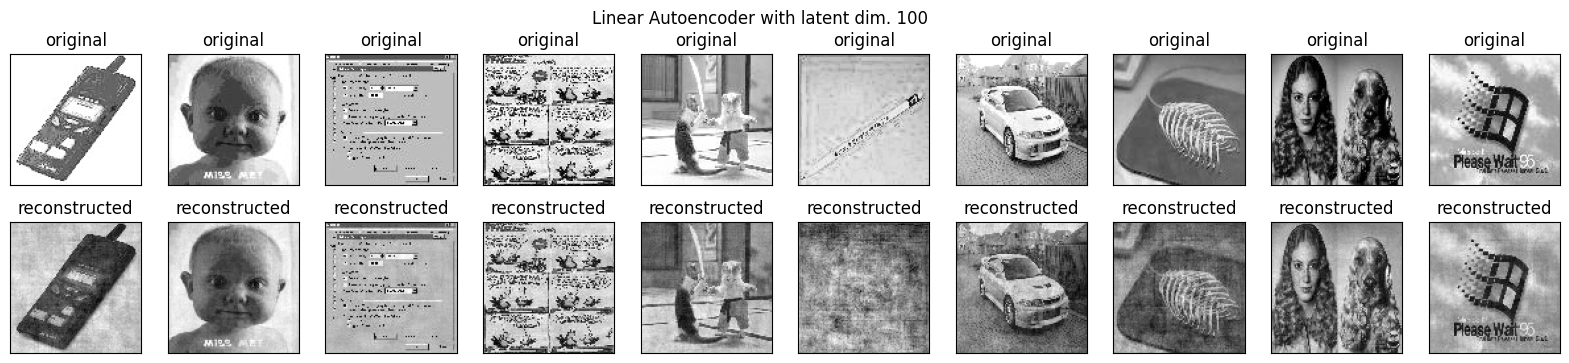

In [22]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Linear Autoencoder with latent dim. 100")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_imgs_100[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig('./images/ae_lin_100.png')
plt.show()


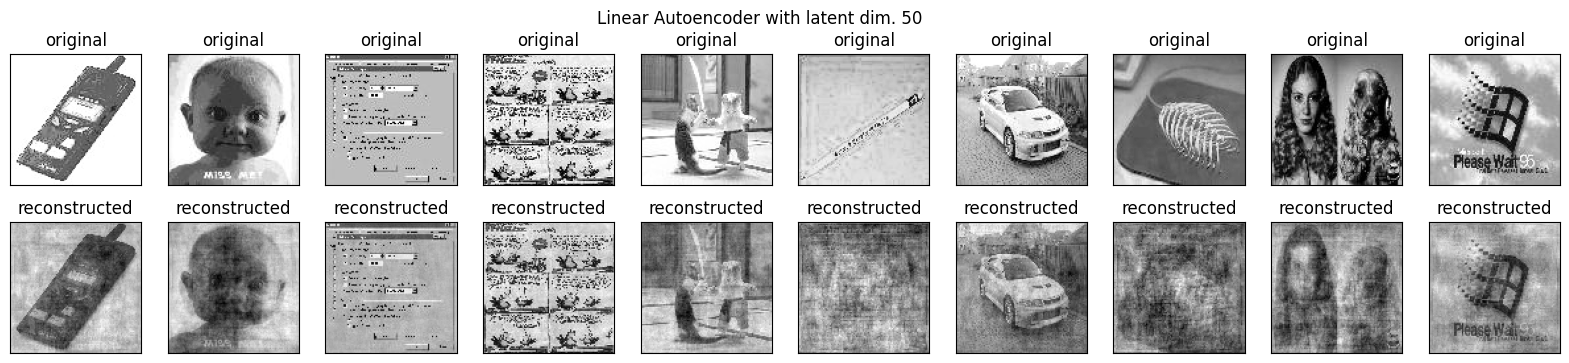

In [23]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Linear Autoencoder with latent dim. 50")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_imgs_50[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig('./images/ae_lin_50.png')
plt.show()

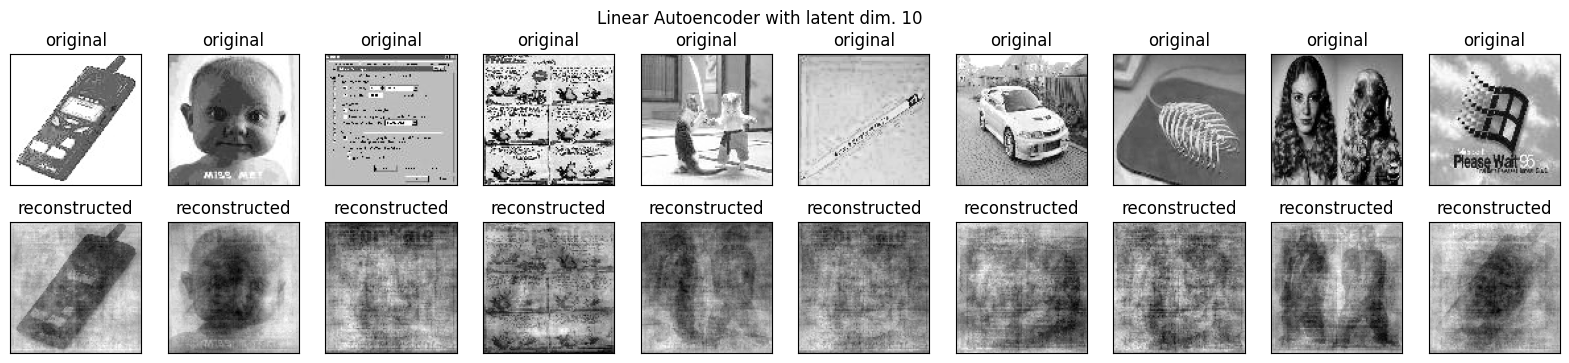

In [24]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Linear Autoencoder with latent dim. 10")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_imgs_10[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig('./images/ae_lin_10.png')
plt.show()